# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=(2**16),alternate_sign=False, ngram_range = (1,2))
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['exclaim_count'] = toxic_data["comment_text"].str.count("\!")

    X_quant_features = toxic_data[["word_count", "punc_count", "exclaim_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_train.csv', my_random_seed=95)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 6735, 'TN': 54176, 'FP': 60478, 'FN': 6267, 'Accuracy': 0.47714952685341855, 'Precision': 0.10020382961629447, 'Recall': 0.5179972311952007, 'desc': 'ols_train'}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12981, 'TN': 114623, 'FP': 31, 'FN': 21, 'Accuracy': 0.9995926552610139, 'Precision': 0.9976175837688288, 'Recall': 0.9983848638670973, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12986, 'TN': 114634, 'FP': 20, 'FN': 16, 'Accuracy': 0.9997179921037789, 'Precision': 0.9984622481931417, 'Recall': 0.9987694200892171, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12196, 'TN': 106283, 'FP': 8371, 'FN': 806, 'Accuracy': 0.9281114871216394, 'Precision': 0.5929887684154228, 'Recall': 0.9380095369943086, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12983, 'TN': 114629, 'FP': 25, 'FN': 19, 'Accuracy': 0.9996553236823964, 'Precision': 0.9980781057810578, 'Recall': 0.9985386863559452, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12576, 'TN': 114605, 'FP': 49, 'FN': 426, 'Accuracy': 0.9962790624804161, 'Precision': 0.9961188118811881, 'Recall': 0.9672358098754038, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 0, 'TN': 114654, 'FP': 0, 'FN': 13002, 'Accuracy': 0.8981481481481481, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/isabelstoddart/Desktop/ML/myWork/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

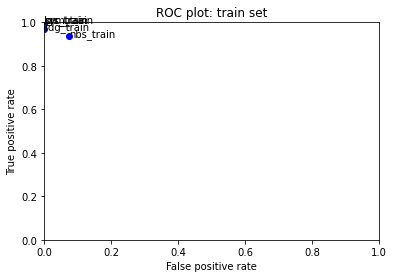

In [12]:
fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [13]:
ols_predictions = ols.predict(X_train)

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
18
I'll be spending the 48 hours whittling down my watch list, as that's what got me into trouble the last time.
* * * * * * * * * 
121
Wish you get well soon. Nothing that cannot wait and never more important than health. Sorry for disturbing you. My best wishes...
* * * * * * * * * 
181
"

 Please do not vandalize pages, as you did with this edit to Horus. If you continue to do so, you will be blocked from editing.   (talk) "
* * * * * * * * * 
192
LOL. oh, I see now. So my behavior on this board grants you the license to make digs and personal attacks against other users? Whatever... Last I checked there is no WK:Retribution rule that lets you trash other users simply because they are not following the rules. So, according to your reasoning, if I break the rules, then it is okay for you to break the rules. You are a hypocrite. You are acting like the official Wiki vigilante who can go after people that you feel aren't following the rules here. I broke th

2682
And I also apologize for being angry. As I said, I am in disbelief, but that does not make that right.
* * * * * * * * * 
2755
After you get the table in there, I can insert the pic.  FYI, to do it yourself, you need to download it onto your computer, upload it under the 'upload file' link under the searchbar.  Then, you simply place the image into the table.  But I can do it, no problem.
* * * * * * * * * 
2781
Sorry for the late response. Heres the soruce saying that Mac Walters is the lead writer... http://blog.bioware.com/2009/10/15/preview-the-dark-horse-mass-effect-comic/   5:19, 25 October 2009 UTC
* * * * * * * * * 
2812
"

Definitely his views contradict the current principles of Wikipedia. I don't think his intention is to comply with them. If no one expresses dissatisfaction and advocates change, there would be no improvement.

On the other hand there are users who are abusing the system covertly, like user Zoe and user Mikkalai. User Zoe is using Wikipedia to torture p

5598
", 7 October 2009 (UTC)

Yea, good idea. ''' 24/7 (C)''' 22:53"
* * * * * * * * * 
5600
"

 Straw poll on Srebrenica massacre 

As a result of persistent edit warring on Srebrenica massacre, I have proposed that a straw poll be taken regarding one of the issues involved—namely, how to title the section currently named ""Alternative views"".  This will help us to determine whether there is a consensus on what to title this section, or at least a consensus on what not to call it.  The straw poll can be found at Talk:Srebrenica_massacre#Straw poll on ""Alternative views"" section.  I have posted this announcement to each of the 19 users who have made multiple edits to Srebrenica massacre this year.  — "
* * * * * * * * * 
5609
"I don't think it's too early. But when ever you decide to add a motive section, it should be made clear that Ivins was very probably a Mossad asset. He was a Jew, and the anthrax case fits a pattern of Israeli false-flag operations. See the books by Viktor Ost

8335
Stargate
Whay did you remove the line that involved when the Stargate was discovered in the article 1928 which was conveniently removed (23, February 2006), shortly after me and my counterpart began research on the reality of the Stargate.
* * * * * * * * * 
8368
For me it's also hard to put them into indie rock (as seen on Discogs). They have a style that doesn't compare to rock music. But i can say, it's some kind of new, modern pop music. Indie Pop could work out.
* * * * * * * * * 
8371
Don't you have a real job? 

Maybe you should read How to talk to a liberal, but only if you must, by Anne Coulter.  Also, maybe you would realize the brilliancy of conservatism if you actually worked.  Liberals are such crazy people!  Almost like children, they can not see the forest for the trees.  So very impractical and non realistic.
* * * * * * * * * 
8403
"

 WikiProject France newsletter 

{| style=""border-spacing:8px;margin:0px -8px"" width=""100%""
|class=""MainPageBG"" style=""width

11067
Well okay then...
[User:SDylanGLC2011]]
* * * * * * * * * 
11095
RJ Preet 

Recreated by Use:Devak31 naru - I've deleted it. As I brought the AfD I won't take action on the editor.
* * * * * * * * * 
11126
Is this trimmed down version acceptable?
* * * * * * * * * 
11136
CORRECT ARTICLE ON MY USER PAGE OKAY
* * * * * * * * * 
11204
"::::It's the first time I've tackled a list like that. I think what I'm going to do is a paragraph for every award (brief description of the award, criteria, etc.) and different table formats for every award, which is the main thing I'll have to figure out.  (Converse) 

"
* * * * * * * * * 
11206
Please refrain from posting innaccurate infomation about my website on your little internet encyclopedia. Thanks.
* * * * * * * * * 
11226
Any interesting things you cam across? (talk)
* * * * * * * * * 
11228
. ManInStone, Sept 2007
* * * * * * * * * 
11258
The article Macournoyer has been speedily deleted from Wikipedia. This was done because the article s

* * * * * * * * * 
11768
}}

{{WikiProject Ireland |nested= |class=Start|importance=Mid|attention= |peer-review= |old-peer-review= |image-needed= |needs-infobox= |listas=
* * * * * * * * * 
11789
The line I put in about the paper's Web site is not a joke edit. It's factual information about the paper's Web site, including its address. Please try not to be so snotty in your response.
* * * * * * * * * 
11849
No, the LLN is a much stronger result than this. It says that you are likely to get close to 17 ONEs in 100 rolls of a die.  This is the fundamental thing that makes statistics worthwhile: if you have a lot of observations then the average of the sample is close to the average of the population. This is why you can , eg, do clinical trials in only a few thousand people and extrapolate to approving drugs for a population of hundreds of millions.   I agree that the article could use revision in the introduction.  I don't really like the proof, either. Only a very small number of peopl

13959
Yoyoyo say what you want.
* * * * * * * * * 
14005
Not really this is my home and the other was at work on break. Besides it just gives you an excuse to block me or take me to ANI or something. It still shows that instead of collaborating on the project or helping to eliminate abusive admins, reviewing articles or any number of other things you continue to waste time. 108.45.104.158
* * * * * * * * * 
14091
"

Fair use rationale for Image:WestPalmsCW.jpg

Thanks for uploading or contributing to Image:WestPalmsCW.jpg. I notice the image page specifies that the image is being used under fair use but there is not a suitable explanation or rationale as to why each specific use in Wikipedia constitutes fair use.  Please go to the image description page and edit it to include a fair use rationale.

If you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of 'image' pages you have edited by clicki

16992
My technostupidity strikes again: I can't find what you're referring to on FPAS' page. Also, I think he's a good guy. Did he really do all that?  | talk .
* * * * * * * * * 
17118
"

Dear Natalie,
First, ""duly noted,"" and it has been on my mind since an earlier flag appeared.  My effort at footnoting ran amuck when I was simply stumped by the wall which kept me from doing it.
I shall shortly dedicate my efforts to better learning the Wiki-methodology and hold back on contributions until I am on top of that.
For example, when the WSJ (Wall Street Journal) reports a press release from the National Home Builders Association, (""NHBA"",)I would assume that correctness would require me to navigate to the NHBA website for the proper reference
Am I correct?  I will try the signature thing with this message.
 "
* * * * * * * * * 
17121
by the way, it claims there were only four characters shown; Mario, Peach, Wario and Waluigi, but did people not see the huge picture of DK as well as i

19727
"
The editor in question is strongly suspected to be Wikipedia:Long-term abuse/Cause of death vandal. A link like CBE is piped through a redirect because if you hover over that link, it shows the full title; and when you click on it, you get the ""(Redirected from Commander of the Most Excellent Order of the British Empire)"" message at the top of the page. It's also a WP:NOTBROKEN situation - one day, we might split out the five different levels into their own articles. The article must not be moved, since it covers seven awards -
Member of the Most Excellent Order of the British Empire (MBE)
Officer of the Most Excellent Order of the British Empire (OBE)
Commander of the Most Excellent Order of the British Empire (CBE)
Dame Commander of the Most Excellent Order of the British Empire (DBE)
Knight Commander of the Most Excellent Order of the British Empire (KBE)
Dame Grand Cross of the Most Excellent Order of the British Empire (GBE)
Knight Grand Cross of the Most Excellent Order

20387
How dare you threaten to block me? Do you know who I am, I am John Jacob Astor, 3rd Baron Astor of Hever not only a succesful buisnessman but also a member of the HOUSE OF LORDS! I will not tolerate this behaviour and will take further action with the law courts of England, which you being Americans, have no idea about our soceity and the way we live. You have made a terrible mistake and would never dream of vandilising, which, because of you Americans, we now have vandilisism in England. But I would never take part in such crime. 

Baron Astor of Hever
* * * * * * * * * 
20729
Cars 2 (film) 

Hi, just to let you know that I've looked at the deletion discussion taking place on this film, and as an alternative, I've also added a merge proposal tag to it, in the event that a merge be possible rather than full-out deletion. I think this is a better alternative, and should be done in the long run. Let me know what you think about it.
* * * * * * * * * 
20734
"

Sorry to take so long 

Actually, I didn't. I removed your incorrect tag placement and provided sources, before you threatened to spank me and you called me a racist.
* * * * * * * * * 
22596
You haven't looked into in the blatant POV and editing history of Malik Shabazz? Is it that you are not interested, agree with his POV pushing, or do you just fear him?
* * * * * * * * * 
22640
Most articles do. It's fine as long as it is NPOV, which it is.  18:42, July 26, 2005 (UTC)
* * * * * * * * * 
22648
"

 Requests for comment/Daniel575 

Hello Daniel: Are you fully aware about the importance of Wikipedia:Requests for comment/Daniel575 as it is a very serious matter and it may adverssely effect your future contributions on Wikipedia. FYI I have place the following comments at Wikipedia:Requests for comment/Daniel575#Outside view by IZAK: Thanks.  

I have two comments: My first comment is in response to '''.)  "
* * * * * * * * * 
22659
the yugo page is ruining my TEXAS business. aren't Texans supposed to stick to

25434
My birthday is today I turned 20  Nevaya
* * * * * * * * * 
25436
Thank you very much! You are much more friendly that some other admins I have met on wikipedia. Hint* Ryulong
* * * * * * * * * 
25455
Please refrain from adding nonsense to Wikipedia, as you did to User:Hurricanehink. It is considered vandalism. If you would like to experiment, use the sandbox.  A link to the edit I have reverted can be found here: link. If you believe this edit should not have been reverted, please contact me.
* * * * * * * * * 
25463
MQM and their Abu Garib Style Terrorism
I saw the debate between Imran Khan, Babar and Ajaz ul haq and I felt sorry for Imran Bhai that he was mistreated for his 
private life matters which was brought up as a more important matter than crimnal history of thug like Altaaf Hussain and his party who only tortures and kills whoever they wants. I have witnessed MQM and their Abu Garib style crimes. My cousin has worked for MQM and he told us that if he leaves the party 

28714
REDIRECT User talk:7D HMS/Archive 1
* * * * * * * * * 
28717
":Both in current numbers (24%) and in historical context, Roman Catholics are a minority religion in America. Even among Christian ""believers"", the ratio is more than two to one in favor of Protestants. This is no suprise: of the 13 colonies, only one had a significant Catholic presence (Maryland). Today, of the 24% Catholics, most (about 12-14% of the country) are now Catholic hispanics, mostly in California, Texas, and Florida (probably more, with undocumented Mexicans). The remainder are mostly Irish and Italian Catholics, in the Northeastern cities. Likewise most Protestants in the country are segregated, and live in the South and Midwest. There is a religious segregation in the country that muddies the appreciation of the ""other"". Of the Protestant/Reformation movement, most are mainline or evangelical/born again/fundamentalist churches. Orthodox are not a Reformation faith, but Mormans and Pentacostals probab

29267
"
Actually you are right. And if you take my suggestion, you have to wait until the Grammys are over as Adele is a sure-fire winner that night. Much content will be added after that I believe. —  (talk2me) "
* * * * * * * * * 
29373
"

Don't thank me, thank . I just scheduled it to be put on the Main Page. Good job on that article btw -) Regards Why "
* * * * * * * * * 
29417
Then how have you kept this sentence and the entire section that it belongs? Some in the psychology community have argued that online therapy can never replace traditional face-to-face therapy.[7] Research from G.S. Stofle and J. suggests that online counseling would benefit people functioning at a moderately high level.[8][9] Severe situations such as suicidal ideation or a psychotic episode might be better served by traditional face-to-face methods.[10] Although further research may prove otherwise.[2]
Clearly cherrypicking and pov
* * * * * * * * * 
29528
I don't object to flags for the teams, I do object

31871
Congratulations, and do let me know if I can ever be of assistance. ++: t/c
* * * * * * * * * 
32004
Actually, you are wrong, that would be an example of a false analogy, not a straw man fallacy. This is a straw man falacy. Always willing to educate -  <3
* * * * * * * * * 
32115
There was a bad redirect that dumped all talk onto the wrong page...
* * * * * * * * * 
32144
See ya
It sure sucks to have 50 edits reverted in a minute. TTFN (Ta Ta For Now).89.205.38.27
* * * * * * * * * 
32198
You realize most of those articles are stating that Turkey has a growing influence in the middle east? the articles I've provided state that Turkey has a growing influence in the Balkans and thus are talking about the same thing. I see no reason to only include the middle east if what you're basing 'regional influence' on is growing influence. Articles such as: http://setimes.com/cocoon/setimes/xhtml/en_GB/features/setimes/features/2012/05/08/feature-05, http://csis.org/blog/western-balkans-turk

34867
As for conspiracies against Syria...
* * * * * * * * * 
34921
"

I don't know anything about the issues surrounding it, but would be best discussed on the talk page to avoid edit warring.♦ Dr. ☠ Blofeld "
* * * * * * * * * 
34923
It's already published freely on-line by the government. Not an issue.
* * * * * * * * * 
34951
Thank you. I did reply, I wonder if the spam filter ate it. I still can't edit, I get a message about my IP address recently being browsed by me and therefore being blocked. But I appreciate you reverting your decision, and no apology needed. And thanks TruSilver for getting involved too -
* * * * * * * * * 
35146
"
  While you are right, it shouldn't be a big deal, it's probably not worth quibbling over.  Just find another article to make comparisons to, I'm sure there has to be a few out there that would suffice. ) Happy editing. — {{U|}} (e • t • c) "
* * * * * * * * * 
35148
Your note
Thank you for your note on my talk page, left on January 7, 2009. You ha

37979
Talk page blanked, editing of talk page disabled. The only reason to edit a talk page of a blocked user is to ask for an unblock (or to discuss said request). As long as his editing of the talk page was minimal and harmless, I ignored it, but when he is bringing external conflicts here, where he is alrzazdy blocked, then it has to stop.
* * * * * * * * * 
38038
I LOVE BRISTOL PALIN. SHE IS THE GOING TO BE SUCH A MILF!
* * * * * * * * * 
38091
00:54 May 25, 2010 (UTC)
* * * * * * * * * 
38120
"

First, NPOV is only violated by you. Why do you say ""of course"" (as EU brings nothing good) and if you look e.g. to England or Poland, most parties are Anti-EU (which does not mean, they want immediately a withdrawal), and that's ""of course"". It are simply facts. Most parties in Europe are Anti-EU, but even if not, why would that be a reason not to mention the parties who speculate about withdrawal?? And why would non-winning in elections be a reason not to mention them?? They seek EU 

40792
And as an addition King Dubya's regime is a fascist one. His take over can be easily compared to Hitler's takeover of the German republic. They are amazingly similar in many ways.
* * * * * * * * * 
40808
3RR 

3RR does not apply to vandalism, which to me would include the adding of a copyrighted image.71.217.206.152
* * * * * * * * * 
40819
Certainly passes WP:N standards, especially those specifically laid out by WikiProject College football.
* * * * * * * * * 
40849
REDIRECT Talk:Age of Conan: Unchained
* * * * * * * * * 
40852
"== Opel Vectra/Saturn Aura ==

Mortonar, I think  (talk • contributions) "
* * * * * * * * * 
40953
I do not go by a real name here.  You are violating WIkipedia rules.  Again, you have a problem here and I am going to escalate it.  Your attempt to discredit me and to dig and print personal information is going to get you in serious trouble, and I am going to make sure of it.  You can disagree all you like.  And by the way you are not in a courtroom,. 

43403
have a look here for footage of Peter Hore the Serial Pest
http://www.hawkmoore.blogspot.com/
* * * * * * * * * 
43520
Self-published and questionable sources about themselves

An important lesson from Wikipedia... and I quote:

Self-published and questionable sources may only be used as sources about themselves, and only if:
 the material used is relevant to the notability of the subject being discussed;
 it is not contentious;
 it is not unduly self-serving;
 it does not involve claims about third parties;
 it does not involve claims about events not directly related to the subject; 
 there is no reasonable doubt as to who authored it;
 the article is not based primarily on such sources.

Emphasis mine. Tiger by the tail?
* * * * * * * * * 
43539
" is hard to read, unreferenced, and confusing for most people who are not familiar with the subject matter. The concept is not well explained, and the article provides little context about what this so-called ""theory"" actually is. T

44228
"

  

Your request to be unblocked has been granted for the following reason(s):
your rite

Request handled by:   "
* * * * * * * * * 
44235
How do you get a site?
Many penguins have asked this question.
It is very simple, just go to www.wordpress.com and you can edit css and buy a domain but you have to pay for it -(.
and you can add other users to be part of you're blog.
and you can get a meebo and a widget and also a million people to come to you're site if you had it for like about 3 or 2 years.
also strancp does have a site ( www.strancp.wordpress.com 
~Strancp~
* * * * * * * * * 
44243
"
All right then. I'll look into it. Thanks for your valuable tips. 66 "
* * * * * * * * * 
44312
Just IEEE Std 1003.1-2004, look at the archives (This was discussed earlier). 83.161.253.7
* * * * * * * * * 
44338
Request for help ignored 
I posted this request for help Wikipedia:No_original_research/Noticeboard#Original_Research_by_editor_Esoglou_on_the_Roman_Catholic.E2.80.93Eastern_Orthod

46179
That section has no substantiated claims and has unverifiable information which is forbidden to have on Wikipedia. No claims have ever been made about Starforce having to be removed via formatting the partition it is installed on because it can be removed via the official removal tool. Therefore I am putting the warning back up.
* * * * * * * * * 
46215
It's cute that you think this will stop me for long.98.180.215.216
* * * * * * * * * 
46292
February 25, 2015 6:46 PM

You deleted our research about Miss Earth 2015. You deleted all the TBA lists in Upcoming National Pageants. Now, we are now having a hard time for researching for every country you've deleted. Thanks for the damages you've done.
* * * * * * * * * 
46428
"

Agree with the first part, the injunction is notable, the extra-marital affair is not. Until the coverage of this goes beyond a couple of rather obscure Irish media sources, it fails WP:BLPNAME and WP:UNDUE. (talk to me) "
* * * * * * * * * 
46508
"

 Deleting 

48820
hahah how is where he services his car relevant??
* * * * * * * * * 
48830
"
No - you were a big loss and everyone felt that way.  But clearly a watch list is a good thing.  It's good to have you back.  I'm very happy that Spring is here and the weather is turning nice again.  If you have particularly buildings, let me know.  Otherwise, I'm working on some non-Wiki projects.  I recently sent out messages on Facebook and MySpace, and via e-mail, that I was no longer doing any large-scale Wiki projects.  These were mistaken as retirement notices, but in reality it's just that I have shifted my creative focus to other areas.  The last round of Film photos were my swan song, to so to speak.  I still have a lot of material to upload, some interviews to publish, and an article to write (Arthur Kramer (attorney)).  Glad you are here!  David '''''' "
* * * * * * * * * 
48868
I did not call you a Nazi.  Rather I compared your authoritarian style behavior to that of the Nazis which is a fi

49659
WWE Championship
Your edit to the WWE Championship article has been reversed as it constitutes vandalism. Please don't add nonsense to the articles.
* * * * * * * * * 
49668
rEstoring it - its a revealing personal detail - reliably sourced - the whole page is like a crappy advert imo  and needs looking at for pov issues  - article started by a single purpose account, anonymous - .
* * * * * * * * * 
49701
I am being punished because an editor, One Night In Hackney, edits my edits and then, when questioned, refuses to answer my questions.  Instead, he asks questions, I respond, yet he ignore my questions.  This is unfair.
* * * * * * * * * 
49702
Maybe we should both mutually ask for a sockpuppet investigation for each other , i think that would be fair ! And let us see who in reality is abusing with wikipedia ... ! I for sure will ask for you astarti34 , if this persists . That user with an ip knows too much about wikipedia for not having an account such as the NPOV term , which 

51873
Sue, do take symbolic action as soon as u read my above message as it is totally unacceptable. Best regards. Bye, till tomorrow.
* * * * * * * * * 
51884
That was a lot of hours ago. And has no connection with my sense of humor, or your lack of it.
* * * * * * * * * 
51887
Seth Ravin
You voted in the DRV for Seth Ravin, and I wanted to let you know that the article is again at AFD: Wikipedia: Articles for deletion/Seth Ravin 2. Thanks. -
* * * * * * * * * 
51897
"
The Sieck article looks like a good find. I'm just ""surfacing"" briefly due to a bout of insomnia, but will have a proper look during daylight hours. All best,   "
* * * * * * * * * 
51980
"

 ""British Isles"" 

Hi. Thanks for your note; I assure you that the detailed explanations you offered weren't necessary — for somebody who doesn't live in Ireland or in the UK, I think I have an excellent knowledge of the region.

Where I differ from you is in my understanding of the word ""British."" To my ears, ""British Isles"

52633
"

 ""DVI and LVDS"" copyright violation 

The sections starting with ""DVI and LVDS"", added in March 2010 by , seem to be copied verbatim from http://www.national.com/nationaledge/may01/lvds.html.  Here's a link from archive.org showing that they had the text long before it was added to Wikipedia.

I've removed those sections."
* * * * * * * * * 
52821
"

 Dear Mr. Jim Handerson, please read the 09:58 16 July 2012 fightingagainstlies edition of the article. You will understand that what I am mentioned. 

Oktay Sinanoğlu (born on August 2, 1934 in Bari, Italy) is a Turkish scientist specializing in theoretical chemistry and molecular biology. In his autobiographical book which titled ""The Turkish Einstein Oktay Sinanoglu Book""[1] he describes himself as: ""A person who was the world's youngest professor in the last 300 years,""[2] ""at the peak of the science in the U.S.A.,""[3] ""a man who reached the level to say, ""I'm God"" in science,""[4] ""the Lord of the U.S.A.,""[5] a

54080
Please see 

Please see the discussion at Template talk:NRHP row#Edit war
* * * * * * * * * 
54082
Transylvania 

I'm hoping you can help me. In a conversation at Talk:Transylvania#TRANSILVANIA.3DARDEAL.3F.3F.3FThen_where_is_BANAT.3F.3F.3FIN_CHINA_.3F.3F.3F, I've been asking two questions that seem simple and straightforward to me, and getting pretty much a run-around from . I'm hoping you might know the answers.   | Talk
* * * * * * * * * 
54086
Discussion notice 

You participated in the discussion at Wikipedia talk:Naming conventions (people)#RFC-birth date format conformity when used to disambiguate so I thought you might want to comment at Wikipedia talk:Naming conventions (people)#Birth date format conformity .28second round.29. (T/C//WP:CHICAGO/WP:FOUR)
* * * * * * * * * 
54092
Please refrain from adding nonsense to Wikipedia, as you did to September 7. It is considered vandalism. If you would like to experiment, use the sandbox.  A link to the edit I have reverted can be 

56813
Please see the bootom of the page for my unblock request**
* * * * * * * * * 
56860
Talking about neutral point of view,how can talking about his works be partial?
If you have written about controversies, then you should also talk about that.
* * * * * * * * * 
56872
Title section revert 

Hi, I was at the office earlier and I hadn't noticed your warning before restoring the title of the section. I'm sorry for that. Of course I won't do such a revert again.

Just to clarify, I've opened a new section to indeed alert some contributors that they were behaving in a way in line with the examples of ownership behaviour as described here. In return the title of the section has been twisted to something unrelated and one of my message has been erased. It is the first time I see people editing other's signed contributions in a talk page. This just looks crazy to me.
* * * * * * * * * 
56901
I believe that the Tatra T603 was a 180 degree V8, if this is true I believe it would be worth men

58032
Perhaps CorporateM should write an article about SLAPP suits, Freedom of Speech, etc. and use these citations in that article. Refrain from hijacking this article to advocate your position on First Amendment stuff.   thenightchicagodied
* * * * * * * * * 
58105
(something Steven Kinzer himself has stated)
* * * * * * * * * 
58256
"

Hi, I noticed that you questioned the credibility of my article on ""Small Town Murder."" Small town murder is indeed an unsigned band that is certainly not on allmusic, but all of the information I have provided is correct, and my source is the band itself. I hope you are not questioning its worth on wikipedia, for it does provide information about a band, regardless of how many people want the information. 

If you want proof that the information is from the band, you may want to view my myspace page and notice the multiple comments back and forth STM and I exchange. I am close friends with every member, and I used to live with one of them, James, t

59319
REDIRECT Talk:Sweet Jesus/Archive 1
* * * * * * * * * 
59332
New paragraph about Collins in historical section

Someone has been copied by some other source. It's better to cancel it directly or to wikify it?
* * * * * * * * * 
59370
Obama's father was muslim this is a proven fact.  His father was born in the arab part of Africa another fact.  Obama was never a chritian before meeting Jerama Wright.  But you would never know this from reading Liberalpedia.
* * * * * * * * * 
59383
Something is wrong 
In the Call out order....AJ was not the first girl to be call 2 times, just once.
* * * * * * * * * 
59385
FWF 

I've declined the speedy tag you placed on FWF. The reason is:
even if it's a hoax, it's not patent nonsense. Let the AfD determine the fate of this page.

For your information,  Od Mishehu
* * * * * * * * * 
59459
I do not appreciate your aggressive tone and uncivilized language. Wikipedia:Civility 
It's becoming clear that expecting anything sensible from you like good f

61036
, 14 March 2007 (UTC)

See Invertible matrix. In the future please add new comments at the end of the talk page. 15:50
* * * * * * * * * 
61126
File:Charlotte Coleman Worzel Annual Cover.jpg listed for deletion 
A file that you uploaded or altered, File:Charlotte Coleman Worzel Annual Cover.jpg, has been listed at Wikipedia:Files for deletion. Please see the discussion to see why this is (you may have to search for the title of the image to find its entry), if you are interested in it not being deleted.
* * * * * * * * * 
61144
"

AfD nomination of Talk:Susan Wald

Talk:Susan Wald, an article you created, has been nominated for deletion. We appreciate your contributions. However, an editor does not feel that Talk:Susan Wald satisfies Wikipedia's criteria for inclusion and has explained why in the nomination space (see also ""What Wikipedia is not"" and the Wikipedia deletion policy). Your opinions on the matter are welcome; please participate in the discussion by adding your comm

63689
"

You twit, take two

You say: 
""Be civil. If you don't agree with an action I made, please be calm and polite. We'll straighten things out a lot quicker without screaming and name calling.""

and then go and post a ""Final Warning"" with respect to ""vandalism"" (see above) which is no such thing. Get a life.
66.185.192.207  "
* * * * * * * * * 
63693
"I think hats are only supposed to have a link to the ""possible other target"", but I could be wrong. 
"
* * * * * * * * * 
63724
To amplify my comment in edit, I think this town was destroyed by the construction of the canal.

It is mentioned as a district of Panama City
* * * * * * * * * 
63737
Of course you can support it. Don't pretend any faux reluctance. You love it. It presents all the self-serving press release crap as facts chiseled in granite, and fails to mention the FBI investigation or any of the 26 indictments or convictions. So it serves your agenda.
* * * * * * * * * 
63749
"

The whole thing is nonsense. Typical

"
* * * * * * * * * 
64387
Why can't this page be editted? 

This event hasn't occured yet so there is still a ton of information still to come to light about this event.  Why is it not even possible to edit it and bring it up to the quality of a stand alone article like every other UFC event?  This is very suspicious.
* * * * * * * * * 
64443
New Category:Sephardic Orthodox rabbis 

Hi Shuki, you'll be pleased to know that I've created a new, objective category - Sephardic Orthodox rabbis. Unlike many other recently created categories that have been bitterly disputed, this category doesn't rank Rabbonim by how Frum they are or their political beliefs. In short, it's absolutely impossible to argue why any of the Rabbis have been placed in it - because of course they're all Sephardi. I hope you like it and that this simplifies matters. Many thanks,
* * * * * * * * * 
64469
"

About serb radical nationalist editors

Hi, I’m posting this anonymously because I don’t want to be annoyed with

65915
I am not sure if the flaps or lugs are actually weaker, but certainly I have seen these fail in old lamp holders and have never seen the pins on a bulb fail. It could be because the lamp has had many bulbs used in it, whereas each bulb only has to be inserted and removed once.
* * * * * * * * * 
65923
yes it did make the album, it is track 15, and confirmed by MTV: the Leak.
* * * * * * * * * 
65930
This is yet another question - what is the player's perceived probability of winning by switching?  Question for you - in the regular set up, if Monty forgets where the car is and opens a door at random (without letting on to anyone that he forgot) but fortuitously reveals a goat, what would you say is the player's chance of winning by switching?  Does it matter whether the player knows Monty forgot?   Rick Block (talk)
* * * * * * * * * 
65975
"But ""cult""?  Well....  "
* * * * * * * * * 
65989
Your Entry: == 
You can obtain a photo of this ship at the following URL:

1. www.navsour

68606
So you're telling me if I was the only participant and I marked my ballot like so:1) Alice2) Bob3) CindyCindy (my lowest preference) would win the election?  (talk - contribs)
* * * * * * * * * 
68609
I understand what you are sayin' mate, but the picture ain't copyrighted.
* * * * * * * * * 
68665
Yeah, I had looked at History of evolutionary thought myself, but I didn't see anything there either. A few specific articles have sections on their controversial aspects (gene-centered view of evolution and punctuated equilibrium), but of course I can only find those if I already know that they're among the current controversies in the field.
* * * * * * * * * 
68668
Believe it or not, I'm actually neutral too. I'm just acting in a systematic way. I saw a small possible issue, and did a quick query/challenge on it, to see if all was actually on the up-and-up. Should have taken say 7 minutes, maybe 70 on a slow day.    Talk about famous last words. -P
* * * * * * * * * 
68684
Having lo

69570
}}
{{unblock|You are reading the wrong ANI entry, that's for a previous block. Please refrain from responding until you're familiar with the issue at hand.Rama's Arrow is selectively applying blocks to members on one side of a large edit conflict. A cursory look at the conflict would show you that the other side is engaged in vandalism to promote an extremist POV.
* * * * * * * * * 
69629
"

 Bowser 

I replaced the New SMB image with the Mario & Luigi image because this version of Bowser had more reception than any version of him in the history of the series. I put it there because it depicts him in a game where he is arguably the main character of the game, not because it's the most recent image. We do not have a ""most recent appearance"" rule because it makes an article unstable, and suggests that we use an image JUST because it's newer, not because it's better. -  used Ruler! Now, he can figure out the length of things easily. "
* * * * * * * * * 
69660
This is not an issue 

71456
Force-Placed Insurance 

Undid page defacement by company PR rep.
* * * * * * * * * 
71553
"

OK- that was odd.  I reverted it again- let me know if this is correct now.  —  talk -  "
* * * * * * * * * 
71557
I'm sorry? (I don't know what you want me to do with this information. -)
* * * * * * * * * 
71594
"

We have any right to demand the protection of human rights for Arvanitas and  Albanian workers in Greece which are very badly treated , your point of views and ""racism"" that you  demonstrate “ hate and loath Albanians today”..  “Despite its membership in the European Union and NATO, human rights violations persisted on an alarming level in Greece ”

 “They noted that Albanian immigrants were frequently ill-treated by the Greek police and authorities at all levels. They were discriminated against in all sectors of life, including the courts; their trials were often unfair, carried out without interpretation for the defendants, and sentences were harsher than those handed do

72336
Trey is NOT an agnostic 

I removed the reference to him being agnostic.  Matt Stone is agnsotic not Trey.  Trey said in a recent interview that he believes in God and even said that he's religious.  However, he said that he doesn't really believe in the stories that are in the Bible, Quran, etc.
* * * * * * * * * 
72358
The secession isn't going to happen.  I remeber they were discussing a secession back when Long Island seceeded in 1993, but then Portland stepped up and gave Peaks more services.  Mostly because Portland can't afford to lose the tax dollars the residents of Peaks provides.  If the debate gets to a point where a movement just might happen, I'm sure Portland will launch a counter-defensive.
* * * * * * * * * 
72476
It used as a geographic term, refering to the conerbation/hinterland. It does seem to be aquiring an offical stats though  AltaVista produced those.
* * * * * * * * * 
72526
There needs to be an update on this.  198.83.120.99
* * * * * * * * * 
72529
{{

74007
It was started as singles match.
* * * * * * * * * 
74049
2nd lever warning

Stop taking back the facts, which you do not know ahout, nobody is removing anything, except what is wrong, grow up
Since you are wrong on Stalin and few other things, I'd like to stay in touch with you, since you are an aministrator, so we can talk abotu other prorblems, once I get back,  I would like one administrator to take care of my postings and other vandals... But let me remind you, this is  a free site, so if I do not post something as beautiful as million dollar baby, be gratefull anyways... and that GOES FOR THE REST OF TIME - WASTERS!
* * * * * * * * * 
74075
"{| style=""background-color:#F5FFFA; padding:0;"" cellpadding=""0""
|class=""MainPageBG"" style=""border:1px solid lightgrey; background-color:lightgrey; vertical-align:top; color:#000000; font-size:85%""|
 Hello, P222PJP! Welcome to Wikipedia! Thank you for your contributions. You may benefit from following some of the links below, whi

74836
Seems to be at it again, in force
* * * * * * * * * 
74857
"

In answer to WBardwin: As to a good source on effects of Little Ice Age, my background is of decades of taking field archeology classes, while living in the area of the ""anasazi"".  None of the things I could cite are in writing, such as books, it comes from lectures.  Of course, the ""anasazi"" did not leave written records, or the entire subject would be much more clear.  
Currently I teach ceramics (pottery) at Eastern Arizona College.  I make ""anasazi"" reproductions that everyone raves about.  I could say I am the incarnation of an ""anasazi"", which I personally believe, and it would be taken with the same disbelief as suggesting that the Little Ice Age (please see the Wikipedia article on this subject)could be causative to the abandonment of the ""anasazi"" homelands.  
A New York Times article of this date (Vanished: A Pueblo Mystery)does mention Little Ice Age, but generally dismisses it as causal, preferrin

76655
, Can't you delete already. Please I no longer want this account. It's not about my talk page.
* * * * * * * * * 
76742
"Hello, Rajan1986, and welcome to Wikipedia! Thank you for your contributions.

I noticed that one of the first articles you edited appears to be dealing with a topic with which you may have a conflict of interest. In other words, you may find it difficult to write about that topic in a neutral and objective way, because you are, work for, or represent, the subject of that article. Your recent contributions may have already been undone for this very reason.

To reduce the chances of your contributions being undone, you might like to draft your revised article before submission, and then ask me or any other editor to proofread it. See our help page on userspace drafts for more details. If the page you created has already been deleted from Wikipedia, but you want to save the content from it to use for that draft, don't hesitate to ask anyone from this list and the

77782
Can you please remove all of the blank space on this graph by re-uploading it because it is not only unsightly but its now very un-user friendly for those of us that want to see it properly. Besides we don't know if there will be a snap election or not (unlikely I know but we don't have and are not allowed to pretend we have a crystal ball are we). I can understand you not wanting to re-upload it now because, it will need to be updated in May as agreed as per it's talk page, so if you want to wait till after the local elections by all means do -) Cheers mate 130.88.114.46
* * * * * * * * * 
77838
In ictu oculi has it right: based on what's in these two articles now, and what they are titled now, they describe the same exact subject, and make only tentative efforts to suggest they're different. I fail to see the need for a separate article on religion, but if we decide we need one, that would really be an entirely new article. As it stands currently, these articles cover the same 

79785
"
Meanwhile, I, his Number 1 ""vulture"", did nothing to him this time. Must have been one of the other ""vultures"". Of which there appear to be a growing list. But all is not lost. It's an inspiration.  What's up, Doc? "
* * * * * * * * * 
79973
"

Please refrain from adding nonsense to Wikipedia, as you did to Project Rockstar. It is considered vandalism. If you would like to experiment, use the sandbox.  "
* * * * * * * * * 
79981
NBA WikiProject Newsletter
* * * * * * * * * 
80047
Maybe enquire at WP:BLACKLIST as to why and see if you can get it accepted? Snowman
* * * * * * * * * 
80057
Hi Drmies. I added the note to my edit summary because attribution there is recommended when translating. I'll see what I can do about the other ones, I do not have that much time these days. (And I only visited the O 13 article because it contained a link to the disambiguation page Frankrijk...)
* * * * * * * * * 
80110
I agree with Bignole too.  Acctually one info box is fine.   ChaosMaste

82604
"

 August 2007 
 Please stop. If you continue to ignore our policies by introducing inappropriate pages to Wikipedia, you will be blocked.  Please stop creating pages based on copyrighted material you paste from tv.com. You've been warned several times, and the information cannot be used on Wikipedia. Thank you.  Ariel♥Gold "
* * * * * * * * * 
82628
Hello 

Sometimes we agree.  Sometimes we don't, but it's all good as far as I am concerned.  I was not referring to you in any of my comments about shenanigans at NARM. The troublesome editors are often single purpose, and appear to be new.  These editors do a grave disservice because their noise tends to shield an editor like Cirt from legitimate criticisms and scrutiny.  You will notice that I did quite the opposite of what Cirt wanted at Santorum (neologism).  I am not any way in the habit of backing up Cirt.  It just happens that often he's right, though sometimes he's wrong. And I dislike the sock campaigns that have been been

83423
"::::::::::::::::I understand where you're coming from, but the complaints seem to indicate that there are cases when you do get it wrong. I've listed this particular IP at WP:OP for a check to clarify the discussion, but I still think your indef blocks here are problematic, in that they're not recommended by WP:IP, and even long blocks of a year or two should not be made unless the IP is confirmed by WP:OP to be an open proxy. I completely understand your laudable desire to prevent damage to the encyclopedia - would it be acceptable for you to, as a compromise, only block IPs you suspect to be open proxies with a shorter duration (the durations typical for vandalism edits) - unless and until WP:OP confirms that they are in fact open proxies? In those cases you can always extend the block if needed. But I'd ask that you cease with the indef blocks in any case, per WP:IP. Thanks!  hi! 
"
* * * * * * * * * 
83447
"
Kunstler said ""They seem to be a particular kind of crank"", not "

85013
...Aaand he's been reported for Personal attacks.
* * * * * * * * * 
85130
Are you monitoring me? 

How did you notice my edit so quickly? The content is true, I just haven't found a reliable reference. I know it's true because I was the other man at the time.66.87.143.199
* * * * * * * * * 
85154
AC WPWW 

Hi. I don't know if you've seen the conversation at Wikipedia talk:WikiProject Women writers#Authority control. It's a huge project, and really needs to include all writer bios, not just women writers, but sticking with WPWW scope, it would be limited to women's. Probably bot, not AWB, right?
* * * * * * * * * 
85183
":::::Rev. Margolin, you are quite correct that LaVey did not originate the term 'satanist', and yet you have yet to demonstrate that LaVey (and his wife, and their comrades) did not invent the religion of Satanism, which was obviously my focus of interest for many moons now. self-ID is not irrelevant as this is one of the criteria for sociological categorization.

86023
"

I could have been ""reminded"" too but was banned and then threatened by you in response. The policy here is often to ban first and ask questions later. I think I am just about done with Wiki. It is a laughing stock of an encyclopedia lampooned daily in the press and print world. ""The Onion, Daily Show, Colbert Report"" have all picked on it for just the kind of thing I encountered daily as an editor here. It seems that censorship is the core issue behind almost all of what afflicts the site yet when it is called out by a fellow contributor, it gets some phony ""we are all friends being neutral"" rhetoric lobbed back and no progress is ever made. You say you are following the ""rules"" even if you are, there are higher rules like ""truth"" which should trump the petty stuff but that whole ""just following orders"" excuse is so typically self defeating it embarrasses me to say I am human. 

At what point does a person ask the tougher question like ""what is the truth"" and hol

87146
"

 Hello, , and Welcome to Wikipedia!
Please remember to sign your name on talk pages by clicking  or  or by typing four tildes (~~~~); this will automatically produce your username and the date. Also, please do your best to always fill in the edit summary field. Below are some useful links to facilitate your involvement.  Happy editing! Snowysusan  
 Getting started Introduction
 The five pillars of Wikipedia
 How to edit a page
 Intuitive guide to Wikipedia Finding your way around Table of contents
 Department directory Editing articles How to develop an article
 Simplified Manual of Style Getting help Frequently asked questions
 Cheatsheet
 Where to ask a question
 Help pages
 New contributors' help page
 Article Wizard – a Wizard to help you create articles How you can help Contributing to Wikipedia
 Community Portal
 Join a WikiProject
 Follow Wikipedia etiquette
 Practice civility"
* * * * * * * * * 
87153
Seriously? 

This IS a different computer, not no one else's. 72.70

88652
Hopefully if we can get T25 its own article this wont be a problem here.
* * * * * * * * * 
88673
You may copy this to the Peer Review page if you want. —  (talk)
* * * * * * * * * 
88718
Aeroméxico destinations 

Please note that I've reverted your edit again . It won't be difficult for you to add a reference for the termination if the airline stopped serving ATL in last April. Let me remind you that WP:VERIFY, which is a policy, applies (and also WP:VNT). Do not reinstate you changes until a suitable source that acknowledges your modifications is added. Thanks.'''' ''
* * * * * * * * * 
88764
|importance = high
|class = start
* * * * * * * * * 
88770
Article about MARZIA PRINCE 

HEY , MAN DON`T DELETE MY ARTICLE ABOUT MARZIA PRINCE. I AM WORKING ON IT. IT IS MY FIRST ARTICLE (!). I DON`T KNOW HOW WIKI WORKS AND IT IS DIFFICULT TO CREATE SOMETHING. IF NOT I, SOMEBODY WILL FIX IT.... I AM NOT AN EXPERT HERE, UNDERSTAND? I DON`T KNOW HOW TO UPLOAD PHOTOS AND STUFF LIKE THAT.... Y

89958
"

 Removed ""Cleanup Tag"" 

I removed the Cleanup Tag placed on the Buddha page.  I think alot of people have made positive contributions, and to me the article looks vastly improved.  If anyone disagrees, please feel free to put the tag back on.  Otherwise, thank you all for your excellent work.  D   "
* * * * * * * * * 
90007
But I do have one point to make regarding assuming good faith on thisif the same IPs are related to seemingly credible entries in the past which have now been adulterated from the same source terminals and it now appears that a parent or someone in a similar position may be trying to rectify it, why haven't they themselves cleaned the entries up?  If they were proficient in wikipedia editing before, why suddenly have they apparently lost their touch?  Logic perhaps isn't my strong suit, but it seems to me to be quite inconsistent and highly suspicious.  I hope to be proven wrong.
* * * * * * * * * 
90113
There are different books of Gothic rock, a genre 

91507
No problem. I'm hoping to finish the categorizing of the road infoboxes by the end of the night. If you catch any other mistakes, let me know. Woohoo!
* * * * * * * * * 
91531
"

Improperly categorized
JCDenton2052 has improperly categorized this as a ""War crime"", notwithstanding the fact that it does not match the guidelines for the related topic.  Looks like excessive POV-editing, which is not helped by his frequent edits of user pages accusing other editors of vandalism.   "
* * * * * * * * * 
91612
I am requested an account on the ACC account creation interface.
* * * * * * * * * 
91620
Southall in West London is dominated by a variety of Indian cuisines (in the strict sense) because the locals are Hindus from areas of India.
* * * * * * * * * 
91631
well i'll just replace it with Princess Anne's royal standard since it is her birthday this week 86.11.172.114
* * * * * * * * * 
91650
. I will not engage in battleground attitude, personal attacks, long-term tendentious editi

92497
There's a whole bloody article on the official Chiefs page confirming Love's Not A Competition! Read it and weep! 

As well as the promo 
And the video 

See? The evidence is too strong for it not to be a single!
* * * * * * * * * 
92515
Does this count as an airliner shootdown incident? 

Your vote at Talk:List_of_airliner_shootdown_incidents would be appreciated )
* * * * * * * * * 
92629
"
I would be surprised since she told me that she put it here.  I suppose it could be possible.  I made my decision primarily on an extensive personal review of the site.  It seems my judgement that the site is largely based on Nikki's personal experiences, and then a list of people who she knows to be pedophiles, but at some time or another have been naturists.  Her conclusion is that there is a causal link between nudity, nudism/naturists and pedophilia.  Her words are strong, and certainly her POV.  There is no backing with any research to support her point.  The net effect is that she smea

94350
What if I use historian Ludo Martens as a source?
* * * * * * * * * 
94390
"

Yes but what you don't understand is the reason I ""interrupted your template"" was because you deleed my edits so don't do it again and you won't have your templates interrupted, comprende?:)"
* * * * * * * * * 
94396
"

Things to throw the public off have been included in marketing campaigns before, but I haven't seen them included here on Wikipedia. For example, part of the original Banshee's logo was revived in the early days of GateKeeper's campaign but there is no mention there (also ""scream like a banshee"" makes no mention).   Talk  "
* * * * * * * * * 
94410
And for the record, the only reason I agreed with the idea of consistency was that I knew that many of the articles at that point were originally in American format and they should be returned. With the majority of the articles in American format and your position behind your position of consistency, I was looking forward to watching you f

95406
The same regime - in essence!!
* * * * * * * * * 
95454
Like the Greens do, something on their site with the image and stating it is released under the creative commons license would be good.
* * * * * * * * * 
95537
Who was it that first judged that the laws of thought are not related in any way to dreaded psychology and its description of brains or minds and their acts of thinking? Was he the same man who claimed that the laws of thought are pure logical principles that would exist somewhere separately even if there were no humans who had thoughts running through their heads?
* * * * * * * * * 
95569
I think you just did ). I was conducting my own form of social research, that is I was prodding at him trying to find out if he actually has any respect for his own stated religious beliefs or if they're just a political tool. I got my answer alright.
* * * * * * * * * 
95587
Unfortunately, it's not. Apparently 楊威利 was used in the official Chinese translation for the animated serie

97054
Hi again Una. I am disappointed that rather than treat my suggestion with the respect it (I think) deserved, you have made a further complaint at AN/I. The possibility exists to improve the article, something we should all wish for. Basic courtesy would have had you at the very least inform me that you were complaining about my actions on a centralised message board; I find your decision not to do this rather disappointing. Tell me, what exactly do you want from this process?
* * * * * * * * * 
97138
"
 Your submission at Articles for creation 
 Suicide Cliff, which you submitted to Articles for creation, has been created. The article has been assessed as Stub-Class, which is recorded on the article's talk page. You may like to take a look at the grading scheme to see how you can improve the article.
You are more than welcome to continue making quality contributions to Wikipedia. .
 If you have any questions, you are welcome to ask at the help desk.
 If you would like to help us 

97920
, 8 September 2008 (UTC)
 No, it is not disruptve to add Ukrainian and Israeli source, why on earth are you reticent about the Israeli source you erased yourself?! This interview was given, it is confirmed by 7 sources from 4 different and independent countries and if you expect me to add a link of the original interview in Hebrew, that is not going to happen, because I do not know the language! You probably do not know Russian too, so abstain from removing disruptively Segodnya's and Vremya Novostei's articles, which you indulged to several times! Your effort to intimidate every user quoting Russian language sources other than the Novaya gazeta is simply harassment.   18:50
* * * * * * * * * 
97991
Vandalism to Tom DeLonge page. IP needs to be banned
* * * * * * * * * 
98037
"

Well it has been changed, also it may have been recorded in 1976 but no singles were released and the album wasn't released then so no one could hear it or buy it. The references are in the inlay booklets

99615
"

 Boogie Nights 

This is not a ""civil"" comment. I am accusing you of being a philistine who has never read the Bible, incidents from which are not typically placed in italics because they are not discrete works of literature. Reverting your idiotic, unfounded reversion.  "
* * * * * * * * * 
99709
Thanks, I will take a look.
* * * * * * * * * 
99728
while i had to go out for a sec then he was on my laptop sorry for what damage he did
* * * * * * * * * 
99759
Michael Fairman Soaps
Thank you for letting me know about the policy. I honestly wasn't aware it. However the vast majority of the news that are reported on MFM, Soapcentral and Daytime Confidential originally come from another source anyway . So I will always prioritize these original sources when I find them. Regards.
* * * * * * * * * 
99863
I replied to this earlier but someone deleted it along with your second warning for the same thing (after which a block came). Here it is again: How many times do you think you ca

102240
"

Wild wolf and Cuchullain

You are both wrong, Wild Wolf, you say Confederate Arizona was apart of Union New Mexico territory. This is completely false. Union New Mexico and Confederate Arizona were two seperate territories one governed by the Union the other governed by the Confederacy. Union Arizona territory did not exist until 1863, the campaigns occurred in 1861 and 1862, at the time of the Mesilla and Valverde engagements happened in the region of Confederate Arizona, this is fact. Whoever changed it back was seriously lazy about it, although I will not explain why.

Cuchullain, you say it should be named New Mexico Campaign because that is what most other people call it. Well I am sorry If I dont think we should babdly name an article because most people are too stupid to realize the fighting occurred in Arizona Territory aswell and not just New Mexico. 

As I said before I am changing this article back to ""East Arizona and New Mexico Campaign"" because this title most

103094
"I agree with the original poster. This article reads like a press release from Obama's office. The one line of ""criticism"" is utterly hilarious. Check out any other senator's site (especially a REPUBLICAN senator's site, and you'll see scads of criticism - even from first-termers. I don't know enough about Obama's record to add critiques, but I guess that's the point. The media and now Wikipedia have been so fauning it's impossible to get a fair viewing of the man and his record. This is a common problem on WP, and must be addressed by neutral observers if it hopes to remain a good resource. -   

"
* * * * * * * * * 
103151
Support per given arguments.
* * * * * * * * * 
103177
"

If you like, I'll take it to arbcom or the like.  Opposing the inclusion of an image that accurately depicts something described in the text is nonsense (it actually refers specifically to a flag that uses Pantone colors that match to those used in the image in question, I'm not talking about where

105055
Tear... 

Awwwww! Your picture of that US soilder with that little Iraqi boy is just so cute! OMG!! That's so sweet. 70.121.33.78
* * * * * * * * * 
105090
"
 Few? I found only one – mav, who, however, noted that the present title is still better. _Zero "
* * * * * * * * * 
105137
has presented you with the Donut of DOOM in the spirit of WikiLove and hopefully this one has made your day a little more gothic. 
  
Bon appetit! 

 
Spread the smell of DOOM by adding .]]
.
* * * * * * * * * 
105145
Thanks for the review. I understand I used tone and level of sarcasm deemed inappropriate on Wiki and agree to keep that in mind going forward as I have during the previous almost a decade without any similar past issues. I let the emotions of anger get the better of me this time while defending from a false accusation and while I consciously took care to curtail my anger by avoiding profanity it definitely seems like I wasn't as receptive to the overall unpleasant tone.
* * * * * * * * *

107483
Pokemon Black and White==
Um, hi. Its Linkbean. Saw your message there and I understand. Didn't know that Bulbapedia wasn't a reliable resource, so I apologize for making you waste your time to delete that. KTHXBAI
==
* * * * * * * * * 
107511
What exaclty are you talking about? See WP:BLP, it has to follow NPOV and also use credible sources not one interview. Talk | email
* * * * * * * * * 
107534
":More to the point, do they need to be here? Sure, they are notable by definition, whether people like that policy or not (plenty do not think that all villages should have a presence, just as plenty think not all high schools should). However, you seem to be suggesting that you are somehow acting on behalf of the  villagers, which is an unusual approach. A stub without context (geo data etc) is particularly meaningless and likely to irritate people with a less tolerant attitude, so perhaps doing a little more basic work on each one would go a long way towards placating the situation

108782
To Doc
To whom Doc is: I advise KF to ignore your actions and denials of petition and just reinstate the article you deleted in its original terms and add the tags he proposes him or herself. If you delete it again, I advised him to complain against you before administrator Remember the dot to overturn your adverse to KF decisions or go to the Arbitration Committee with a complaint and if as a last resort, bring judicial action against you. Your abuse needs to be stopped. You seem mean spirited, crude and abusive of your power. I figure you're going to try to block me. If you do, I'll appeal to Remember the dot or Arb Comm, or last resort legal options which is something I don't relish doing, but is always a last card to play I suppose.
* * * * * * * * * 
108797
NO VANDALISM committed QUIT your HARRASSMENT & Thuggery 

Dear wiki thug, there was no vandalism of the Maitreya article by me. The Baha'is have not made a case as to why there should be a mention of their creed in an ar

110176
BMW NOT unit construction
R and K series have a separate gearbox bolted to the crankcase. The term bolt-up unit construction is sometimes applied as was the case with the original BSA A7 where the separate gearbox bolted to the crankcase.  Also consider the Nimbus where the gearbox and engine use a common oil supply but the gearbox is again bolted to the engine. Most of the American fours used a true unit construction. Given the opening definition can 2-strokes be considered unit construction as most used premix or a separate oil supply to the crankcase?
* * * * * * * * * 
110277
This dude's buddy, eh? If not, check  this out.
* * * * * * * * * 
110331
WikiProject NCSU
Since you went to NCSU, maybe you should join WikiProject NCSU, which was started today.
* * * * * * * * * 
110419
If memory serves, in addition to the Salon reference, there were a couple of college papers that discussed it, which may no longer be web searchable, but yes, the dichotomy between blogosphere and RS 

111704
Coming Clean 

I know a load of administrators must be watching this page, so I am going to tell you all this right here:

TABThe recent antics (Nanook Vandalism etc.) preformed by this anonymous user (216.164.203.90) were preformed on purpose, as a part of an experiment.  I am currently writing to you from my place of work, located in Boston, Mass, USA.  I have chosen to perform this unorthodox experiment from my workplace, in order to avoid negative votes on my possible upcoming election as an administrator, on the Wikipedia username I use from home.  The main purpose of this experiment was to know, first hand, what vandalism “feels like,” from the vandals’ point of view.  Let me tell you, “I have learned a lot” 
TABI appreciate how you all quickly reverted vandalism and left welcoming warning messages in the beginning.  When I continued to vandalize “Wolf” I appreciated how you all “Assumed Good Faith.”  However, Kim van der Linde, at times you forgot to stay “As cool as a cu

112967
"SOME HISTORICAL DATA FOR KEMAH, TEXAS

 NATIVE INHABITANTS 

The history of Kemah, Texas goes back more than 180 years. The Karankawa Indians, a group of five nomadic, linguistically related groups including the Cocos, Cujanes, Karankawas proper, Coapites, and Copanos, occupied the area from Galveston Bay to Corpus Christi Bay during the late Spring and Summer months. Evidence of the Karankawas near present-day Kemah was discovered back in the 1890s. This discovery will be discussed later in the article. Indian inhabitants began to leave when European settlers arrived, and most had retreated from the area by 1850.

 THE DISAPPEARING FOUNDER 

The recorded history of Kemah began in the early 1800s, when Texas was still under the Mexican flag. On August 24, 1824, the Mexican government granted a labor (approx. 177 acres) of land to to a settler by the name of Michael Gouldrich. Gouldrich was listed as one of Stephen F. Austin’s first colonists in 1826, a widower over 50 years of 

114529
Meetup 

Do you fancy a meet up at any point? I don't think we've ever been introduced. 79.75.171.154
* * * * * * * * * 
114600
for two reasons. (1) no evidence that its notable enouygh (2)
* * * * * * * * * 
114654
"*Check this out.  Apparently Buckles served for a short time in the New York National Guard.  We should add that. -  • Talk • Coor. Online Amb'dor • 

"
* * * * * * * * * 
114663
"
Again, you cannot cut and paste material from one Wikipedia article to another without including attribution. I can understand how it may have been a test edit the first two times, but now that it has been pointed out to you that it is not allowed you must stop.bons mots "
* * * * * * * * * 
114673
Well since nobody is going to do the justice thing, it seems I have to take matters into my own hands. dragong4
* * * * * * * * * 
114682
Speedy deletion of Shoot Out 

 A tag has been placed on Shoot Out, requesting that it be speedily deleted from Wikipedia. This has been done for the followi

115581
Sockpuppets and impersonators 

The two above sockpuppet/impersonator accounts, including
* * * * * * * * * 
115631
, 6 December 2007 (UTC)
Really?  Conquest is not a historian?  Or is he just not using the historical approach?  Please keep in mind WP:NPOV, and remember that this is not StalinistPedia.   21:27
* * * * * * * * * 
115680
You're the Vandal!

Leave my good buddies Tyar and Stopdroproll alone. Just because they live near each other doesn't mean they are the same hupan!
* * * * * * * * * 
115701
Do you even know the meaning of Pop or how they sound like?
* * * * * * * * * 
115715
I suspect that it is you with some hidden reasons are trying to blacklist the best poems site

Someone is spamming the site 'best poems' from various different IP addresses over many months. It is a generic commercial poetry site that generates revenues from advertising and offers links to poetry text. It offers no unique value. [7] [8] [9] [10] [11] [12] [13] [14] [15] [16] [17] There are ma

117362
Main Page Talk 

I think another enhancement we need at Wikipedia is a breathalyzer.  The bars in New York City close at 4:00 a.m.  If one starts at 8:00 p.m. . . . Well, you do the math -)
* * * * * * * * * 
117419
Thanks, my bad, I only looked at the edit that deleted it. P
* * * * * * * * * 
117470
Convert to Puritanism or die? 

The bit about forced conversions on the sometimes enforced threat of death need some reference, it does not seem plausible.
* * * * * * * * * 
117527
I believe the benefit that you are seeking is the fact that towns which are designated as both a Township and a Village and/or a Town and a Borough receive funding from the state based on their designation.
* * * * * * * * * 
117529
Block|I was not using my computer when these edits happened.
* * * * * * * * * 
117537
"

No problem!  ""The Network"" is everywhere, by the way!  We operate all over the country; block one IP and we just jump to another.  Our chapters are everywhere!12.44.74.2  "
* * * * * 

118380
What's the joke?
Many obvious jokes referred to on Wikipedia are horribly over-explained, but this one I don't get at all.
* * * * * * * * * 
118423
, who passed away recently
* * * * * * * * * 
118453
Why did 4kids skipped about 30+ episodes? 

Why did 4kids skipped about 30+ episodes?
* * * * * * * * * 
118488
"

Speedy deletion of Oliver walsh
 Please refrain from introducing inappropriate pages such as Oliver walsh, to Wikipedia. Doing so is not in accordance with our policies. If you would like to experiment, please use the sandbox 

If you think that this notice was placed here in error, you may contest the deletion by adding  to the top of the page (just below the existing speedy deletion or ""db"" tag), coupled with adding a note on the article's talk page explaining your position, but be aware that once tagged for speedy deletion, if the article meets the criterion it may be deleted without delay. Please do not remove the speedy deletion tag yourself, but don't hesitate

120080
No censorship 

There's no censirship
* * * * * * * * * 
120186
"
I think zwie is a now-lost form of a word that meant ""twice"" rather than ""two"".  There's a German etymological dictionary online somewhere that would know (Etymologisches Wörterbuch der deutschen Sprache) but I cant seem to find it now. Soap— "
* * * * * * * * * 
120206
"
Well done, Xav. ;) Check out user:AGK/Advice for new Administrators if you have a mo'! All the best,  "
* * * * * * * * * 
120380
"

 Please do not remove content from pages without explanation, as you did with this edit to Computer-mediated communication. If you continue to do so, you may be blocked from editing.    "
* * * * * * * * * 
120396
"

 Good work 

Thanks for improving the Mirko Filipovic article. Sancho "
* * * * * * * * * 
120439
Leaving certificate 

it says this on the website
are you blind?

Irish Leaving Certificate
The points required for entry in 2007 are likely to be similar to those required in 2006 (570 points).

Six Ye

121091
Additions of http://.forexmarketnews.org  
Please do not add inappropriate external links to Wikipedia. Wikipedia is not a mere directory of links nor should it be used for advertising or promotion.  Inappropriate links include (but are not limited to) links to personal web sites, links to web sites with which you are affiliated, and links that exist to attract visitors to a web site or promote a product.  See the external links guideline and spam policies for further explanations of links that are considered appropriate.  If you feel the link should be added to the article, then please discuss it on the  rather than re-adding it. See the welcome page to learn more about Wikipedia. Thank you.
* * * * * * * * * 
121136
amazons, after all
I think I found the source of the connection of the labrys with the amazons: sagaris 

 saga^ris , eôs Ion. ios, hê; pl. sagareis Ion. -i_s:a weapon used by the Scythian tribes, Hdt.1.215, 4.5;

 A. axinas sagaris eichon Id.7.64 ; by the Amazons,

122719
North & South India 
Since the quirks used in both regions differ so much from each other, i suggest we classify them under different headings, ones used in the four southern states, and the ones used in the rest of the country. Looking forward to a clean and not-too-lengthy discussion.
* * * * * * * * * 
122723
Plagiarism 

This is a copy and paste job from Encyclopedia.com
* * * * * * * * * 
122816
Hello Darkwarriorblake, in regards to the cast of Prometheus, I ask permission to add bullets to the names of Sean Harris and Rafe Spall. Firstly, I think it would help highlight the information that their characters pertain, and their quotes on the film. I think it's a safe assumption that the two are relevant enough to be highlighted as the two were named in the opening credits (as opposed to Benedict Wong and Emun Elliot). It would be very much appreciated, thank-you.
* * * * * * * * * 
122835
"

Turtle Ship
The claim that iron cladding on the turtle ship is controversial is a pe

123504
":I do not see any legitimate justification for removing the cited note that the university has the nickname ""The U"".   

"
* * * * * * * * * 
123621
You mean, not remove a comment I made, but that was completely ignored by you? Isn't this addition of a comment altering your talk page. Besides, it is a page in wikipedia, which means the public can edit it.
* * * * * * * * * 
123726
On the contrary, the article already shows quite nicely how the holiday's origins are in the British Isles and how it's continued to be observed there. There's not really much to say about the holiday outside the Anglosphere. —gr
* * * * * * * * * 
123730
"=bison hair=  

No bigfoot researcher made any big deal of this, since the hairs were not yet tested. If you have questions on suhc things, ask Beckjord, who is here. The best hair analysis was done by three 
scientists, and no further need have been done. http://www.beckjord.com/bigfoot/bloodandhair.html
Current hair analysis, a waste of tiome no

125391
Why did you revert my edit
I'm at a loss to explain why you reverted my edit to Pure Reason Revolution. I thought it would give you plenty of kudos in your quest to become an admin. If somebody compared me, albeit mistakenly, to Jon Courtney I'd feel dead chuffed, presumably you did too? However, I can understand your POV in keeping it a secret between you and your close friends at the London meet, as I know you have expressed your delight to quite a few of them. All the best
* * * * * * * * * 
125400
"

Yes, wonderful and kudos to you.Nvvchar. "
* * * * * * * * * 
125464
Ok, thank you for correcting me. I was trying to find their appropriate subcat but I guess they don't have one yet.
* * * * * * * * * 
125469
"
I've had a go at tidying up the article by putting all the stuff about classrooms in one paragraph. I've also removed all the references to ""non-disabled"" children as there seemed to be an implicit suggestion that all children with special needs are disabled which is 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1679, 'TN': 13733, 'FP': 14959, 'FN': 1544, 'Accuracy': 0.4829077236409212, 'Precision': 0.10091357134270947, 'Recall': 0.5209432206019237, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1975, 'TN': 27229, 'FP': 1463, 'FN': 1248, 'Accuracy': 0.9150556164812784, 'Precision': 0.5744618964514252, 'Recall': 0.6127831213155446, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1900, 'TN': 27396, 'FP': 1296, 'FN': 1323, 'Accuracy': 0.9179382735390882, 'Precision': 0.5944931163954944, 'Recall': 0.589512876202296, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 2054, 'TN': 26154, 'FP': 2538, 'FN': 1169, 'Accuracy': 0.8838477205075983, 'Precision': 0.44729965156794427, 'Recall': 0.6372944461681663, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1965, 'TN': 27182, 'FP': 1510, 'FN': 1258, 'Accuracy': 0.9132696224345919, 'Precision': 0.5654676258992806, 'Recall': 0.6096804219671114, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1836, 'TN': 27715, 'FP': 977, 'FN': 1387, 'Accuracy': 0.9259282469058436, 'Precision': 0.6526839672947031, 'Recall': 0.5696556003723239, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 0, 'TN': 28692, 'FP': 0, 'FN': 3223, 'Accuracy': 0.899013003289989, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

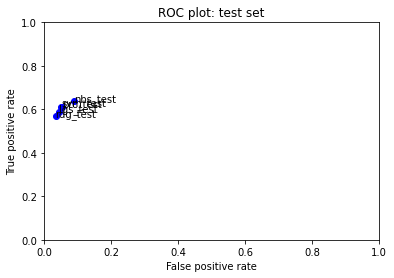

In [22]:
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_test.csv', my_random_seed=95, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 65536)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  exclaim_count
0          72          10              0
1          13           1              0
2          16           0              0
3          38           3              0
4           7           

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5222114857277167


In [25]:
raw_data.head()

,id,comment_text,word_count,punc_count,exclaim_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0


In [26]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,True
2,00013b17ad220c46,False
3,00017563c3f7919a,True
4,00017695ad8997eb,False


In [27]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation